**Ujian Praktek_Data Science_Nopandi Ariyanto
PREDICT**

# **Import Library**
Library yang digunakan untuk perhitungan variable, melakukan visualisasi data dan membuat pemodelan deep learning

In [ ]:
import math
import numpy as np #library perhitugan variable
import pandas as pd             
import matplotlib.pyplot as plt  
import seaborn as sns #library visualisasi data
import plotly.express as px
import plotly.graph_objects as go

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential #library pemodelan deep learning
from keras.layers import Dense, LSTM, Dropout, GRU
from tensorflow.keras.optimizers import SGD

import warnings
warnings.filterwarnings('ignore')

# **Data Preparation**
Pada bagian ini menyiapkan dataset dari TLKM

#Load Dataset

Menampilkan data set yang digunakan dan melihat data 5 teratas

In [ ]:
#Menyiapkan data TLKM
data = pd.read_csv('TLKM.JK.csv')

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,3980.0,3980.0,3980.0,3980.0,3310.131592,0.0
1,2017-01-03,3950.0,3990.0,3920.0,3950.0,3285.180664,71660600.0
2,2017-01-04,3880.0,3980.0,3880.0,3950.0,3285.180664,68494500.0
3,2017-01-05,3960.0,4030.0,3940.0,3950.0,3285.180664,74018400.0
4,2017-01-06,3970.0,4010.0,3960.0,4000.0,3326.765381,44136900.0


Kita bisa melihat jumlah baris dan kolom pada dataset, yaitu terdapa 1422 baris dan 7 kolom

In [ ]:
data.shape

(1422, 7)

# **Data Preprocessing**

Melakukan check pada data, tidak terdapat data yang duplicate pada data set yang kita gunakan ini. 

In [ ]:
data.duplicated().sum()

0

Data yang kita gunakan masih terdapat mising value

In [ ]:
data.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

Kita hilangkan data mising value tersebut dengan melakukan drop pada data yan tidak dikenali

In [ ]:
data = data.dropna(how='any',axis=0)
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Menampilkan informasi data di bawah ini terdapat 6 feature, dan hanya Date data yang bertipe objek

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1421 entries, 0 to 1421
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1421 non-null   object 
 1   Open       1421 non-null   float64
 2   High       1421 non-null   float64
 3   Low        1421 non-null   float64
 4   Close      1421 non-null   float64
 5   Adj Close  1421 non-null   float64
 6   Volume     1421 non-null   float64
dtypes: float64(6), object(1)
memory usage: 88.8+ KB


Kita lakukan perubahan pada tipe data Data yang sebelunya objek, kita ubah menjadi datetime agar mempermudah pada saat proses mengkategorikan data tersebut

In [ ]:
data["Date"] = pd.to_datetime(data["Date"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1421 entries, 0 to 1421
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1421 non-null   datetime64[ns]
 1   Open       1421 non-null   float64       
 2   High       1421 non-null   float64       
 3   Low        1421 non-null   float64       
 4   Close      1421 non-null   float64       
 5   Adj Close  1421 non-null   float64       
 6   Volume     1421 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 88.8 KB


Menampikan data setahun terakhir dengan menambahkan value 12 sebagai bulan dan 30 sebagai hari yang akan ditampilkan pada visualisasi data Close ada data 1 tahun terakhir yaitu tahun 2021-2022

In [ ]:
#Membuat data satu tahun terakhir dengan nilai index
data = data[-12*30:].reset_index(drop=True)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-03-12,3440.0,3480.0,3430.0,3450.0,3168.497070,100195200.0
1,2021-03-15,3440.0,3450.0,3380.0,3380.0,3104.208984,50077300.0
2,2021-03-16,3400.0,3410.0,3360.0,3360.0,3085.840820,60111200.0
3,2021-03-17,3410.0,3430.0,3370.0,3390.0,3113.392822,61701400.0
4,2021-03-18,3450.0,3480.0,3430.0,3450.0,3168.497070,101896400.0
...,...,...,...,...,...,...,...
355,2022-08-26,4510.0,4540.0,4480.0,4490.0,4490.000000,184317100.0
356,2022-08-29,4370.0,4550.0,4360.0,4520.0,4520.000000,101529800.0
357,2022-08-30,4580.0,4620.0,4480.0,4480.0,4480.000000,118884300.0
358,2022-08-31,4420.0,4600.0,4420.0,4560.0,4560.000000,175300400.0


# **Exploratory Data Analysis**

Selanjutnya kita melakukan eksplorasi pada dataset yang kita gunakan. Di bawah ini kita sedikit mencari kapan dimulainya, ditutup dan berapa lama proses transaksi pada harga saham TLKM

In [ ]:
print("Starting date: ", data.iloc[0][0])
print("Ending date: ", data.iloc[-1][0])
print("Duration: ", data.iloc[-1][0]-data.iloc[0][0])

Starting date:  2021-03-12 00:00:00
Ending date:  2022-09-01 00:00:00
Duration:  538 days 00:00:00


Menampilkan visualisasi berupa line plot dari data x yaitu Date dan y sebagai Close. Ditampikan visualisasi sebagai berikut

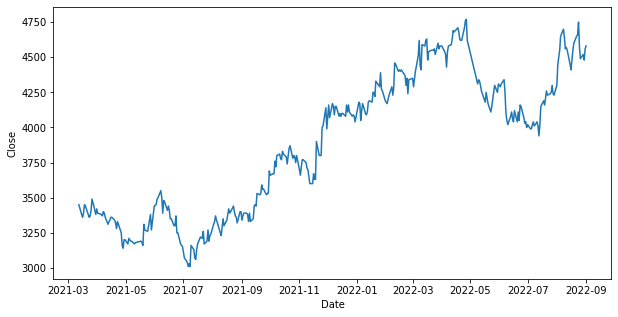

In [ ]:
plt.figure (figsize=(10,5))
sns.lineplot(data=data, x='Date', y='Close')

 Menambahkan variable baru pada data yaitu year, month dan month_year untuk mengkategorikan dan melihat hasil berdasarkan Bulan dan Tahunnya

In [ ]:
#Membuat variable df untuk mengkategorikan bulan dan tahun
df = data.copy()
df['year'] = pd.Index(df['Date']).year
df['month'] = pd.Index(df['Date']).month
df['month_year'] = df['Date'].dt.to_period('M')

Menampilkan visualisasi Distribusi dari harga Open, High, Low, dan Close dengan mengkategorikan variable year dan mencari rata-rata pertahunnya.

In [ ]:
#Mengkategorikan distribusi Open, High, Low dan Close pertahun
stocks_year = df.groupby(by='year').mean()
fig = px.bar(stocks_year, x=stocks_year.index, 
             y=stocks_year.iloc[:,:4].columns,
             title="Distrubitions of Opening, High, Low and Closing Prices by Years",
             barmode = 'group',text_auto=True)
fig.show()

Selanjutnya kita menampilkan visualisasi Distribusi dari harga Open, High, Low, dan Close dengan mengkategorikan variable year dan mencari rata-rata perbulannya.

In [ ]:
#Visualisasi rata-rata harga saham pertahunnya
stocks_year = df.groupby(by='month').mean()
fig = px.bar(stocks_year, x=stocks_year.index, 
             y=stocks_year.iloc[:,:4].columns, 
             title="Average Stock Prices by Month",
             barmode = 'group',text_auto=True)
fig.show()

# **Modeling Long Short Term Memory (LSTM)**

Pada saat modeling menggunakan LSTM kita hanya memakai satu variable index dan satu variable sebagai target, yaitu Close. Maka kita seleksi variable data Date dan Close.

In [ ]:
# Seleksi data Date dan Close sebagai feature
tlkm_log = pd.DataFrame(columns=["Date","Close"])
tlkm_log["Date"] = data["Date"]
tlkm_log["Close"] = data["Close"]
s
# Specify datetime frequency
tlkm_log.dropna(inplace=True)

# ts_log.dropna(inplace=True)
tlkm_log

,Date,Close
0,2021-03-12,3450.0
1,2021-03-15,3380.0
2,2021-03-16,3360.0
3,2021-03-17,3390.0
4,2021-03-18,3450.0
...,...,...
355,2022-08-26,4490.0
356,2022-08-29,4520.0
357,2022-08-30,4480.0
358,2022-08-31,4560.0


In [ ]:
# Mengubah varible Date menjadi Index
tlkm_log.set_index('Date', inplace=True)
#check datatype of index
tlkm_log

,Close
Date,
2021-03-12,3450.0
2021-03-15,3380.0
2021-03-16,3360.0
2021-03-17,3390.0
2021-03-18,3450.0
...,...
2022-08-26,4490.0
2022-08-29,4520.0
2022-08-30,4480.0


# Train test split

Selanjutnya melakukan data training dan testing pada data yang kita gunakan tlkm_log. Pada contoh ini kita gunakan 80% baris pertama sebagai data train dan 20% sisanya sebagai data test.

In [ ]:
# Menentukan banyaknya data train yaitu sebesar 80% data
train_size = int(len(tlkm_log) * 0.8)
train = tlkm_log[:train_size]
test = tlkm_log[train_size:].reset_index(drop=True)

# Data Training MinMaxScaler

Melakukan scaling pada data train dan test dari targetnya yaitu Close dan menampilkan variable Close setelah dilakukan scaling. Setelah dilakukan scaling terdapat penurunan pada data di tahun 2021 dan mengalami kenaikan pada tahun 2022.

In [ ]:
#Melakukan proses data training dan testing menggunakan MinMaxScaller
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train[['Close']])

training_scaled = scaler.transform(train[['Close']])
testing_scaled = scaler.transform(test[['Close']])
train

,Close
Date,
2021-03-12,3450.0
2021-03-15,3380.0
2021-03-16,3360.0
2021-03-17,3390.0
2021-03-18,3450.0
...,...
2022-05-12,4300.0
2022-05-13,4260.0
2022-05-17,4180.0


In [ ]:
#Menyiapkan data train sebelum dilakukan hypertunning pada Model
X_train = []
y_train = []
for i in range(30, training_scaled.shape[0]):
    X_train.append(training_scaled[i-30:i,0])
    y_train.append(training_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# Create Model Parameters LSTM(Unit & Dropout)

Melakukan hypertuning pada parameter, dengan mencoba kombinasi nilai LSTM unitnya 50 dan peluang dropout 0,2 untuk mendapatkan hasil yang terbaik.

In [ ]:
#Arsitektur Model LSTM
lstm_reg = Sequential()
#Layer pertama Model LSTM
lstm_reg.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
lstm_reg.add(Dropout(0.2))
#Layer kedua Model LSTM
lstm_reg.add(LSTM(units=50,return_sequences=True))
lstm_reg.add(Dropout(0.2))
#Layer ketiga Model LSTM
lstm_reg.add(LSTM(units=50,return_sequences=True))
lstm_reg.add(Dropout(0.2))
#Layer keempat Model LSTM
lstm_reg.add(LSTM(units=50,return_sequences=True))
lstm_reg.add(Dropout(0.2))
#layer kelimat Model LSTM
lstm_reg.add(LSTM(units=50))
lstm_reg.add(Dropout(0.2))

#Hasil layer Model LSTM ditentukan oleh ReLU
lstm_reg.add(Dense(units=1, activation='relu'))

#Hasil compile model
lstm_reg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 50)            2

Mencari hasil terbaik untuk nilai loss pada Model LSTM dengan optimizer adam

In [ ]:
#Compile model LSTM
lstm_reg.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics='mae')

#Fitting model pada data train
lstm_reg.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
9/9 [==============================] - 16s 94ms/step - loss: 0.1238 - mae: 0.2814
Epoch 2/50
9/9 [==============================] - 1s 84ms/step - loss: 0.0387 - mae: 0.1585
Epoch 3/50
9/9 [==============================] - 1s 103ms/step - loss: 0.0218 - mae: 0.1135
Epoch 4/50
9/9 [==============================] - 1s 99ms/step - loss: 0.0171 - mae: 0.1041
Epoch 5/50
9/9 [==============================] - 1s 83ms/step - loss: 0.0149 - mae: 0.0969
Epoch 6/50
9/9 [==============================] - 0s 51ms/step - loss: 0.0145 - mae: 0.0979
Epoch 7/50
9/9 [==============================] - 1s 56ms/step - loss: 0.0139 - mae: 0.0987
Epoch 8/50
9/9 [==============================] - 1s 59ms/step - loss: 0.0130 - mae: 0.0912
Epoch 9/50
9/9 [==============================] - 0s 54ms/step - loss: 0.0157 - mae: 0.1020
Epoch 10/50
9/9 [==============================] - 0s 51ms/step - loss: 0.0125 - mae: 0.0916
Epoch 11/50
9/9 [==============================] - 1s 56ms/step - loss: 0.013

In [ ]:
input = scaler.fit_transform(tlkm_log)
input[-1,0]

0.8920454545454544

In [ ]:
#Menyiapkan data test untuk prediksi
X_test = []
y_test= []
for i in range(30,input.shape[0]):
    X_test.append(input[i-30:i,0])
    y_test.append(input[i,0])S
X_test,y_test = np.array(X_test),np.array(y_test)
y_pred = lstm_reg.predict(X_test)
y_pred[-1,0]

0.92402965

Membuat variable dan fungsi Mean Square Error (MSE) menggunakan parameter test dan predicted

In [ ]:
#Membuat variable dan fungsi MSE
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    print("The Mean Squared Error = {}.".format(mse))

Memvisualisasikan prediksi harga saham dari Model LSTM berdasarkan hasil data testing dan prediksi

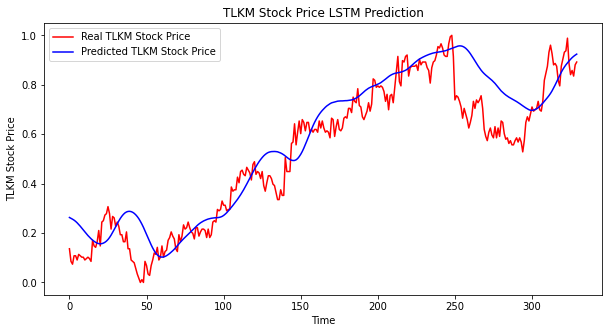

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_test,color="red",label="Real TLKM Stock Price")
plt.plot(y_pred,color="blue",label="Predicted TLKM Stock Price")
plt.title("TLKM Stock Price LSTM Prediction")
plt.xlabel("Time")
plt.ylabel("TLKM Stock Price")
plt.legend()
plt.show()

In [ ]:
# Menampilkan hasil perhitungan MSE Evaluasi Model LSTM
return_mse(y_test,y_pred)

The Mean Squared Error = 0.011825426247456701.


Berdasarkan perhitungan nilai MSE dari Model LSTM maka diperoleh hasil Mean Squearer Error = 0.01182

# Create Model Parameters GRU(Unit & Dropout)

Melakukan hypertuning pada parameter, dengan mencoba kombinasi nilai GRU unitnya 50 dan peluang dropout 0,2 untuk mendapatkan hasil yang terbaik.

In [ ]:
# GRU Arsitektur
gru_reg = Sequential()
# Layer pertama Model GRU
gru_reg.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
gru_reg.add(Dropout(0.2))
# Layer kedua Model GRU
gru_reg.add(GRU(units=50, return_sequences=True))
gru_reg.add(Dropout(0.2))
# Layer ketiga Model GRU
gru_reg.add(GRU(units=50, return_sequences=True))
gru_reg.add(Dropout(0.2))
# Layer keempat Model GRU
gru_reg.add(GRU(units=50, return_sequences=True))
gru_reg.add(Dropout(0.2))
# Layer kelimat Model GRU
gru_reg.add(GRU(units=50))
gru_reg.add(Dropout(0.2))

# Hasil layer Model LSTM ditentukan oleh Sigmoid
gru_reg.add(Dense(units=1, activation='sigmoid'))

#Hasil compile model
gru_reg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 50)            7950      
                                                                 
 dropout_5 (Dropout)         (None, 30, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 30, 50)            15300     
                                                                 
 dropout_6 (Dropout)         (None, 30, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 30, 50)            15300     
                                                                 
 dropout_7 (Dropout)         (None, 30, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 30, 50)           

Mencari hasil terbaik untuk nilai loss pada Model GRU dengan optimizer SGD

In [ ]:
# Compile model GRU
gru_reg.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error', metrics='mae')
# Fitting model pada data train
gru_reg.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
9/9 [==============================] - 8s 50ms/step - loss: 0.0797 - mae: 0.2539
Epoch 2/50
9/9 [==============================] - 0s 51ms/step - loss: 0.0779 - mae: 0.2510
Epoch 3/50
9/9 [==============================] - 0s 50ms/step - loss: 0.0761 - mae: 0.2479
Epoch 4/50
9/9 [==============================] - 0s 51ms/step - loss: 0.0732 - mae: 0.2426
Epoch 5/50
9/9 [==============================] - 0s 54ms/step - loss: 0.0706 - mae: 0.2376
Epoch 6/50
9/9 [==============================] - 1s 58ms/step - loss: 0.0679 - mae: 0.2325
Epoch 7/50
9/9 [==============================] - 1s 61ms/step - loss: 0.0643 - mae: 0.2262
Epoch 8/50
9/9 [==============================] - 1s 60ms/step - loss: 0.0600 - mae: 0.2190
Epoch 9/50
9/9 [==============================] - 1s 62ms/step - loss: 0.0549 - mae: 0.2084
Epoch 10/50
9/9 [==============================] - 1s 61ms/step - loss: 0.0478 - mae: 0.1942
Epoch 11/50
9/9 [==============================] - 1s 60ms/step - loss: 0.0381 

In [ ]:
#Menyiapkan data test untuk prediksi
X_test = []
y_test= []
for i in range(30,input.shape[0]):
    X_test.append(input[i-30:i,0])
    y_test.append(input[i,0])
X_test,y_test = np.array(X_test),np.array(y_test)
y_pred = gru_reg.predict(X_test)
y_pred[-1,0]

0.8644461

Memvisualisasikan prediksi harga saham dari Model GRU berdasarkan hasil data testing dan prediksi

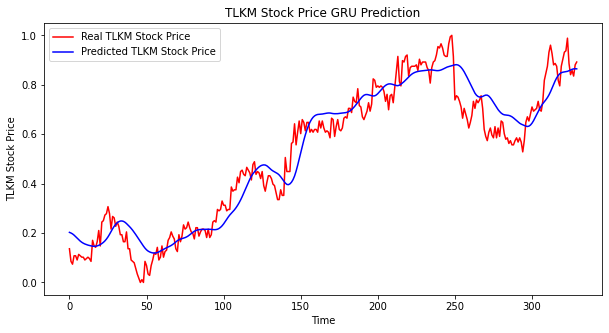

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_test,color="red",label="Real TLKM Stock Price")
plt.plot(y_pred,color="blue",label="Predicted TLKM Stock Price")
plt.title("TLKM Stock Price GRU Prediction")
plt.xlabel("Time")
plt.ylabel("TLKM Stock Price")
plt.legend()
plt.show()

In [ ]:
# Menampilkan hasil perhitungan MSE Evaluasi Model GRU
return_mse(y_test,y_pred)

The Mean Squared Error = 0.005888035060882174.


Berdasarkan perhitungan nilai MSE dari Model GRU maka diperoleh hasil Mean Squearer Error = 0.0058

# **Kesimpulan**

* Prediksi  harga  saham memakai data Close sebagai fiture sesuai di data 2021-2022 dengan menerapkan kinerja model, yaitu melakukan hypertunning pada model LSTM dan GRU pada unit: 50 dan dropout: 0.2 berdasarkan 5 layer dan output layer dengan activation: ReLU(LSTM) dan Sigmoid(GRU) serta compiling menggnakan optimizer: adam(LSTM), SGD(GRU), loss: mean_squared_errror dan melakukan fitting pada model dari data train, epoch: 50, dan batch size: 32 yang digunakan.

* Hasil yang  terbaik  prediksi  harga  saham dari Model LSTM didapat dengan perhitungan Mean Squered Error memperoleh hasil MSE: 0.0118. Sedangkan perhitungan Model GRU dengan Mean Squered Error memperoleh hasil MSE: 0.0058. Perhitungan nilai MSE yang rendah atau MSE mendekati nol menunjukkan bahwa hasil prediksi sesuai dengan data aktual. 

* Dengan  demikian dapat  disimpulkan bahwa penerapan model GRU lebih baik dibandingkan dengan model LSTM dalam memprediksi harga saham TLKM, mampu menanggulangi  ketergantungan  jangka 
panjang  dan  mampu  memprediksi  harga 
saham dengan hasil yang akurat.